### Installs, imports and settings

In [1]:
%%capture
!pip install transformers datasets evaluate

In [2]:
!export PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128

In [3]:
from datasets import load_dataset, load_metric, Audio
from transformers import AutoFeatureExtractor, WavLMModel, TrainingArguments, Trainer
import torch
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Audio as IPythonAudio
from sklearn.metrics import confusion_matrix

In [4]:
DATASET_NAME = "reralle/n-f-n"
BASE_MODEL = "microsoft/wavlm-large"
AUDIO_LENGTH_SEC = 5

## Loading and preprocessing data

In [5]:
dataset = load_dataset(DATASET_NAME)

labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
num_labels = len(id2label)

dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))

length_choice = AUDIO_LENGTH_SEC * 16000

feature_extractor = AutoFeatureExtractor.from_pretrained(BASE_MODEL)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/784 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/60 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/reralle___parquet/reralle--n-f-n-147d97f68619c59e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Sending data through the model

In [6]:
model = WavLMModel.from_pretrained(
    BASE_MODEL, 
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

In [7]:
num_datapoints = 60
num_time_steps = 249
hidden_size = 1024

# Initialize a list of numpy arrays for each time step
time_step_outputs = [np.zeros((num_datapoints, hidden_size)) for _ in range(num_time_steps)]

# Iterate through the datapoints
for i in range(num_datapoints):
    # Preprocess the audio input
    inputs = feature_extractor(dataset["test"][i]["audio"]["array"], sampling_rate=feature_extractor.sampling_rate, 
                               max_length=length_choice, 
                               truncation=True, return_tensors="pt")

    # Get the model outputs
    with torch.no_grad():
        outputs = model(**inputs)

    # Squeeze out the batch dimension and convert to a numpy array
    last_hidden_states = outputs.last_hidden_state.squeeze(0).cpu().numpy()

    # Iterate through the time steps and store the hidden layer for the current datapoint
    for t in range(num_time_steps):
        time_step_outputs[t][i] = last_hidden_states[t]


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Averaging over time for the first plot:

In [11]:
# Stack the arrays along a new axis (axis=0)
stacked_arrays = np.stack(time_step_outputs, axis=0)

# Compute the mean along the new axis (axis=0)
average_array = np.mean(stacked_arrays, axis=0)

print(average_array.shape) 

(60, 1024)


PCA:

In [12]:
from sklearn.decomposition import PCA
reduced_dim = 50

# Apply PCA to each time step output
pca = PCA(n_components=reduced_dim)
reduced = pca.fit_transform(average_array)

In [13]:
reduced[-1].shape

(50,)

TSNE:

In [14]:
from sklearn.manifold import TSNE

# Apply t-SNE to each PCA-reduced time step output
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10)
tsned = tsne.fit_transform(reduced)

In [15]:
tsned[-1].shape

(2,)

Plotting:

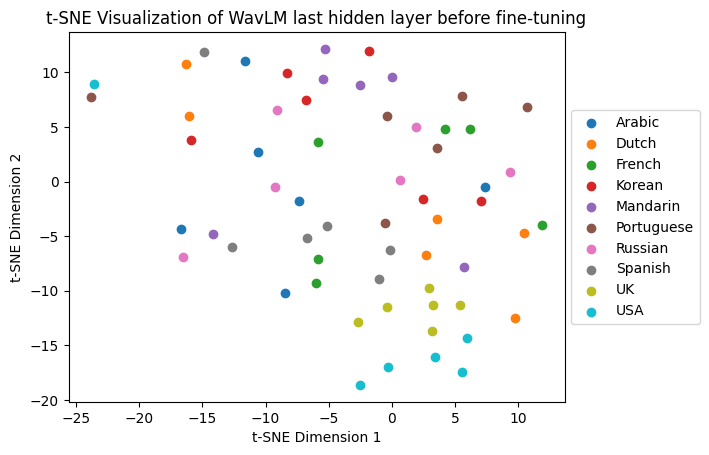

In [20]:
import matplotlib.pyplot as plt

# Extract the ground truth class IDs
class_ids = dataset["test"][:]["label"]

# Get the unique class IDs and their corresponding labels
unique_class_ids = np.unique(class_ids)
unique_labels = [id2label[str(id)] for id in unique_class_ids]

# Create a scatterplot with different colors based on class ID
for class_id, label in zip(unique_class_ids, unique_labels):
    # Get the indices of datapoints with the current class_id
    indices = np.where(class_ids == class_id)

    if label == 'uk':
      label = 'UK'
    elif label == 'usa':
      label = 'USA'
    else:
      label = label.capitalize()

    # Extract the x and y coordinates of these datapoints
    x_coordinates = tsned[indices, 0]
    y_coordinates = tsned[indices, 1]

    # Plot the datapoints with the current class_id using a unique color and label
    plt.scatter(x_coordinates, y_coordinates, label=label)

# Add axis labels (optional)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Add a title (optional)
plt.title("t-SNE Visualization of WavLM last hidden layer before fine-tuning")

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()


Alternative plot where each timepoint in the utterance is displayed separately

In [18]:
input_array_2d = stacked_arrays.reshape(-1, stacked_arrays.shape[-1])

# Apply PCA to reduce the last dimension to 50
pca = PCA(n_components=50)
pca_transformed = pca.fit_transform(input_array_2d)

# Apply t-SNE to reduce the last dimension to 2
tsne = TSNE(n_components=2)
tsne_transformed = tsne.fit_transform(pca_transformed)

# Reshape the transformed array back to 3D (shape: 499, 100, 50)
output_array = tsne_transformed.reshape(stacked_arrays.shape[0], stacked_arrays.shape[1], -1)

print(output_array.shape)

(249, 60, 2)


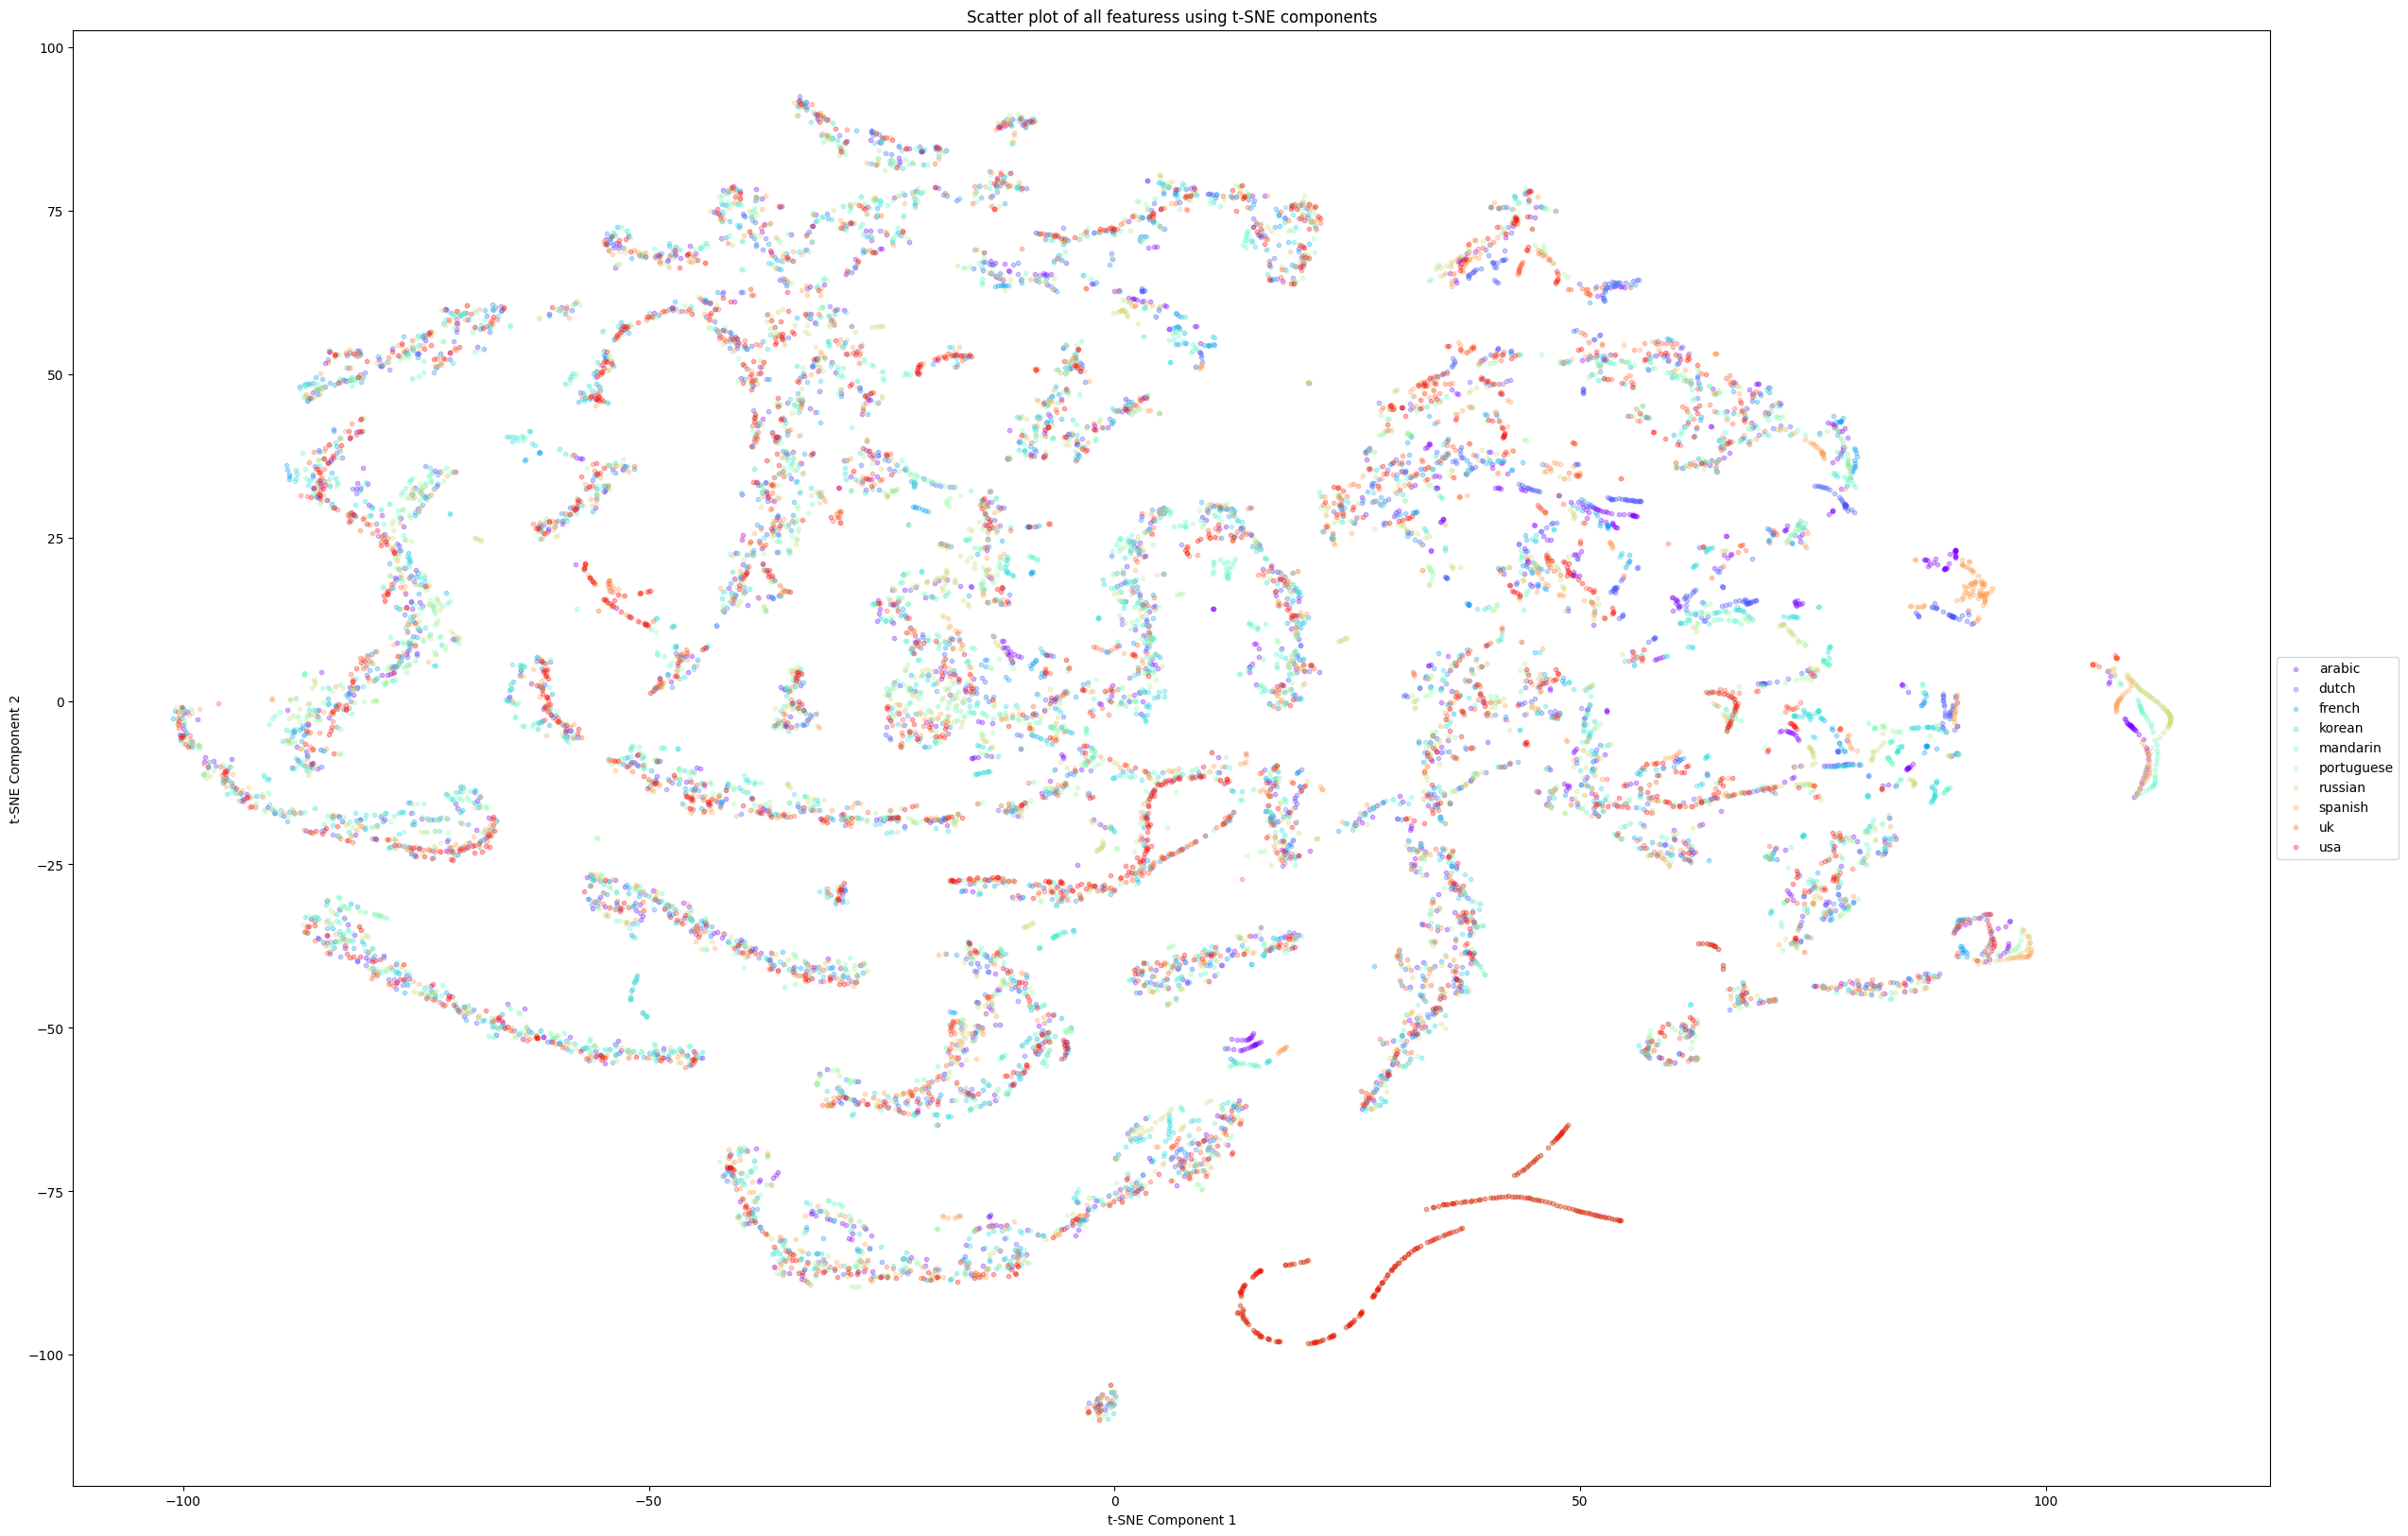

In [19]:
class_ids = dataset["test"][:]["label"]

# Create a scatter plot
fig, ax = plt.subplots(figsize=(30,20))

# Create a colormap for the labels
unique_labels = list(id2label.values())
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
label_color_map = dict(zip(unique_labels, colors))

for subject in range(output_array.shape[1]):
    x = output_array[:, subject, 0]
    y = output_array[:, subject, 1]
    class_id = class_ids[subject]
    label = id2label[str(class_id)]
    ax.scatter(x, y, color=label_color_map[label], label=label, alpha=0.3, s=10)

# Remove duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Scatter plot of all featuress using t-SNE components')
plt.show()